# Проект "Банк - анализ оттока клиентов" #

## МАТЕРИАЛЫ:

Презентация https://disk.yandex.ru/i/ucZc6Jp7o4C4cg

Цель проекта - анализ оттока клиентов «Метанпромбанка». В распоряжении аналитика - данные, полученные из маркетингового отдела банка. В них входит информация о клиентах, их городе проживания, пол, возраст, баланс на счете и другая информация. Есть также признаки отточности клиента, на основании вышеперечисленного необходимо выявить сегменты клиентов, которые склонны уходить из банка. Это поможет более адресно сооставить план работы для маркетингового отдела.

## Предобработка данных ##

### Загрузка данных  

In [ ]:
!pip install phik

In [ ]:
# импортируем все необходимые библиотеки, которые могут понадобиться в исследовании
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
import matplotlib.ticker as ticker
import math as mth
import numpy as np
from scipy import stats as st
import plotly.express as px
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore") # добавим игнорирование ошибок.

In [ ]:
# чтение файла с данными и сохранение в banks
try:
    bank = pd.read_csv(r'D://Elena/Documents/Final_DA/bank_scrooge.csv')
except:
    bank = pd.read_csv('/datasets/bank_scrooge.csv')

### Проверка типов данных   

In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [ ]:
# приводим названия всех столбцов к нижнему регистру
bank.columns = bank.columns.str.lower()
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [ ]:
# переименуем userid в user_id
bank=bank.rename(columns = {'userid':'user_id'})

### Проверка пропусков в соответствии с классификацией (MCAR, MAR, MNAR) и оцениваем возможность их заполнения, проверка на дубликаты, неявные дубликаты     

In [ ]:
def data_review (data):
    print('Первые 10 строк:')
    display(data.head(10))
    print('Последние 10 строк:')
    display(data.tail(10))
    print('ТИПЫ ДАННЫХ\n')
    display(data.info())
#    print('СТАТИСТИЧЕСКАЯ СВОДКА')
#   display(data.describe()) - строка в данном проекте не нужна
    print('ПРОПУСКИ\n')

    for element in data.columns:
        if data[element].isna().sum() > 0:
            print(element, ' - ', data[element].isna().sum(), 'пропусков\n')
            count = +1
        else: print(element, ' - пропусков НЕТ\n')
    print('\nПРОЦЕНТ ПРОПУСКОВ ИЗ ВСЕГО ДАТАСЕТА')
    display(data.isna().mean().sort_values(ascending=False)*100)
    print('\nДУБЛИКАТЫ\n')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов НЕТ')

In [ ]:
data_review (bank)

Первые 10 строк:


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


Последние 10 строк:


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
9990,162357,822.0,Ярославль,М,31.0,3,646575.17,1,1,1,88297.63,0
9991,122366,840.0,Ярославль,Ж,44.0,3,326619.71,1,1,0,157589.59,0
9992,167165,813.0,Рыбинск,М,48.0,2,179765.62,2,1,0,133972.11,1
9993,219924,884.0,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0
9994,114186,851.0,Ростов,М,42.0,3,370912.79,2,1,0,102123.93,1
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0
9999,96267,828.0,Рыбинск,Ж,58.0,3,1180886.70,4,0,1,21422.37,0


ТИПЫ ДАННЫХ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


None

ПРОПУСКИ

user_id  - пропусков НЕТ

score  - пропусков НЕТ

city  - пропусков НЕТ

gender  - пропусков НЕТ

age  -  26 пропусков

equity  - пропусков НЕТ

balance  -  2295 пропусков

products  - пропусков НЕТ

credit_card  - пропусков НЕТ

last_activity  - пропусков НЕТ

est_salary  - пропусков НЕТ

churn  - пропусков НЕТ


ПРОЦЕНТ ПРОПУСКОВ ИЗ ВСЕГО ДАТАСЕТА


balance          22.95
age               0.26
user_id           0.00
score             0.00
city              0.00
gender            0.00
equity            0.00
products          0.00
credit_card       0.00
last_activity     0.00
est_salary        0.00
churn             0.00
dtype: float64


ДУБЛИКАТЫ

Дубликатов НЕТ


В датасете мы имеем 12 полей, всего 10 000 записей, по столбцу age  -  26 пропусков (0,26%), по столбцу balance - 2295 пропусков (22.95%). Явные дубликаты не обнаружены.

In [ ]:
# в нашем датасете только актуальные данные, т.е. все клиенты на данный момент являются действующими,
# а значит у них есть минимум один продукт, проверим что в этом столбце
product0=bank.query('products==0')
product0

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Данные об этой 79-летней пенсионерке, не собирающейся дальше обслуживаться в банке можно удалить.

In [ ]:
bank=bank.loc[bank['products']!=0]

In [ ]:
# Рассмотрим пропуски в столбце "Возраст" - 'age'
age_na=bank.loc[bank['age'].isna()]
age_na

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


Скорее всего пропущенные значения полностью случайны (MCAR): их отсутствие не зависит от любой другой переменной в наборе данных, но в ряде строк отсутствие этих данных сопровождается отсутствием данных о балансе. Поскольку пропуски составляют всего лишь 0,26% от всего датасета, их удаление не окажет критичного влияния на результаты анализа.

In [ ]:
# удаляем строки с пропусками в возрасте
bank.dropna(subset=['age'], inplace = True)

In [ ]:
# смотрим пропуски в столбце 'balance'
balance_nan=bank.loc[bank['balance'].isna()]
balance_nan

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Ростов,М,38.0,0,NaN,1,0,0,171763.69,0
9984,125941,729.0,Ярославль,Ж,42.0,0,NaN,1,1,1,687538.70,0
9993,219924,884.0,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0


В данном случае имеет смысл предположить, что  механизм формирования пропусков - MNAR (при котором данные отсутствуют в зависимости от неизвестных факторов), но отсутствие данных о балансе сопровождается нулевым значением индекса собственности, проверим данное предположение

In [ ]:
# проверим, сколько счетов с нулевым балансом:
balance0=bank.query('balance ==0')
balance0

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3900,179831,730.0,Ярославль,М,18.0,0,0.0,2,1,1,64548.33,0
6757,148456,813.0,Ярославль,М,20.0,2,0.0,2,1,0,23876.51,0


In [ ]:
# проверим, сколько записей с отсутствующими значениями сопровождает нулевое значение индекса недвижимости:
balance_equity=bank.query('balance.isna()', 'equity'==0)
balance_equity

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Ростов,М,38.0,0,NaN,1,0,0,171763.69,0
9984,125941,729.0,Ярославль,Ж,42.0,0,NaN,1,1,1,687538.70,0
9993,219924,884.0,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0


In [ ]:
# проверим также сколько записей без данных о балансе и с нулевыс equity имеют отрицательный показатель отточности:
balance_equity_churn=balance_equity.query('churn==0')
balance_equity_churn.sample(5)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4981,145801,979.0,Ярославль,Ж,58.0,0,NaN,1,1,1,641603.27,0
2421,221740,905.0,Рыбинск,Ж,50.0,0,NaN,1,1,1,132279.19,0
5733,208241,909.0,Ярославль,Ж,39.0,0,NaN,1,1,1,263091.65,0
2015,212845,907.0,Ростов,М,50.0,0,NaN,2,1,1,72530.59,0
5682,128564,899.0,Ростов,Ж,38.0,0,NaN,2,1,1,130407.38,0


In [ ]:
balance_nan.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2278.000000,2278.000000,2278.000000,2278.000000,0.0,2278.000000,2278.000000,2278.000000,2.278000e+03,2278.000000
mean,171915.451273,865.314750,42.076822,0.050044,NaN,1.163740,0.815628,0.549166,2.264338e+05,0.005268
std,33306.706956,89.550489,11.919094,0.218083,NaN,0.403065,0.387873,0.497686,1.998249e+05,0.072404
min,114182.000000,642.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,2.027403e+04,0.000000
25%,142986.750000,871.000000,33.000000,0.000000,NaN,1.000000,1.000000,0.000000,1.202695e+05,0.000000
50%,172376.000000,903.000000,40.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.743542e+05,0.000000
75%,201258.500000,922.000000,49.000000,0.000000,NaN,1.000000,1.000000,1.000000,2.403970e+05,0.000000
max,229145.000000,990.000000,86.000000,1.000000,NaN,3.000000,1.000000,1.000000,1.333687e+06,1.000000


In [ ]:
balance_nan_corr = balance_nan[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']]
balance_nan_corr.sample(5)

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4900,910.0,36.0,0,NaN,1,0,1,172192.01,0
543,903.0,49.0,0,NaN,1,1,1,291165.26,0
1401,724.0,38.0,0,NaN,1,1,0,190291.13,0
9269,888.0,23.0,0,NaN,1,1,1,79881.18,0
1965,908.0,33.0,0,NaN,1,1,0,199578.30,0


In [ ]:
# средние значения по всем признакам по всему датафрейму
bank_nan_mean=bank.loc[:, 'score': 'churn'].mean()
# средние значения по всем признакам по срезу с пропусками в балансе
balance_nan_mean=balance_nan.loc[:, 'score': 'churn'].mean()
# сравнение полученных объектов series методом compare
mean_compare=balance_nan_mean.compare(bank_nan_mean)
#меняем названия колонок
mean_compare=mean_compare.rename(columns = {'self':'balance_nan', 'other':'bank'})
# добавляем столбец, считающие процентное изменение между двумя датафреймами
mean_compare['diff']=mean_compare['bank']/mean_compare['balance_nan']#*100-100
# сортируем по процентному изменению
mean_compare.sort_values(by='diff')

,balance_nan,bank,diff
est_salary,226433.776313,147799.115241,0.652726
credit_card,0.815628,0.680237,0.834004
last_activity,0.549166,0.522912,0.952193
score,865.314750,848.671212,0.980766
age,42.076822,42.730773,1.015542
products,1.163740,1.871653,1.608309
churn,0.005268,0.182292,34.605134
equity,0.050044,2.630803,52.569909
balance,NaN,827245.587515,NaN


Корреляцию по срезу с пропущенными данными в балансе в phik сделать не получится - phik удаляет столбцы с пропусками, поэтому возьмем корреляцию этого признака с другими признаками в полном датасете, закодировав значения.  

In [ ]:
# посмотрим корреляцию баланса ко всем признакам по всему датафрейму
bank_balance_nan = bank.copy()
# делаем столбец, где пропускам присвоим 1, а остальным значениям 0
bank_balance_nan['balance_code'] = bank_balance_nan['balance'].apply(lambda x: 1 if pd.isna(x) else 0)
# убираем столбец баланса
bank_balance_nan = bank_balance_nan.drop('balance', axis =1)
# выводим корреляцию
phik_overview = bank_balance_nan.phik_matrix(interval_cols= ['score','est_salary','age']).round(2)

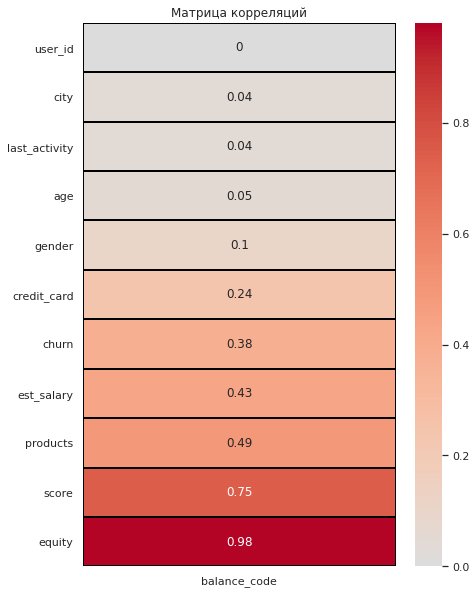

In [ ]:
# выводим график по кодированному столбцу баланса
plt.figure(figsize=(7, 10))
sns.heatmap(phik_overview.loc[:,['balance_code']].drop('balance_code').sort_values('balance_code'), annot=True, cmap='coolwarm',center=0, linecolor='black', linewidths=1)
plt.title(f'Матрица корреляций')
plt.show()

Изменение средних значений всех признаков по всему датафрейму по отношению к срезу с нулевыми значениями баланса показывает наибольшее смещение средней по баллу недвижимости, затем - признак отточности и количества продуктов. Проверка корреляции баланса по всему датафрейму также на первое место ставит балл недвижимости.

Т.о. почти все записи с отсутствующим значением баланса имеют нулевое значение equity, а также отрицательный показатель отточности. Для целей анализа можно просто заменить отсутствующие записи на нулевые значения, а при необходимости поступить как с "заглушкой" и отфильтровать их, вместе с ними отфильтруется всего 2 записи с реальными данными с нулевым балансом, что также не окажет существенного влияния на результаты анализа.  
Также важно отметить, что ситуация, когда в актуальных данных отсутствует информация о балансе клиентов может говорить об ошибке выгрузки данных, что необходимо обговаривать с разработчиками.

In [ ]:
bank['balance'] = bank['balance'].fillna (0)

Теперь посмотрим неявные дубликаты. В данном случае проверка дубликатов имеет смысл только по столбцу user_id

In [ ]:
# проверим дублирование по user_id
dubles=bank.loc[bank.duplicated(['user_id'], keep=False)]
dubles.sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,0.00,1,0,1,119247.61,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,0.00,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2302,220816,934.0,Рыбинск,Ж,74.0,5,1294285.39,3,1,0,95606.80,0
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1
4216,226719,903.0,Рыбинск,Ж,63.0,0,0.00,1,1,0,138582.58,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1


Здесь можно отметить, что речь идет не столько о неявных дубликатах, сколько о задвоении номеров пользователей, которое наблюдается у двух филиалов - в Рыбинске и Ярославле, судя по отдельным показателям (возрасту, оценке недвижимости, балансу) можно сказать, что это разные люди, а присвоение одинаковых user_id - скорее несогласованность между филиалами или техническая проблема. Удалять эту информацию нецелесообразно.  

### Кодирование данных там, где это требуется (город, пол)

Для последующего применения среднего и рассчета корреляции какого-то числового показателя с категориальным неупорядоченным, применим one-hot кодирование при помощи pandas.get_dummies().

In [ ]:
# чтобы не потерять оригинальный столбец, стоит сделать его копию и использовать параметр columns
## (чтобы перекодированию подверглись только те столбцы, которые нам нужно перекодировать)
bank1=bank # эту допольнительную копию пришлось делать, т.к. drop_first не работает и убирает изначальный столбец
bank=pd.get_dummies(bank, columns=['gender'], drop_first=False)
bank=pd.get_dummies(bank, columns=['city'], drop_first=False)
bank

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Ростов,city_Рыбинск,city_Ярославль
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0
2,120722,892.0,30.0,0,0.00,1,1,1,107683.34,0,1,0,0,1,0
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,27.0,1,78144.65,1,0,1,18943.64,0,0,1,0,1,0
9996,139170,894.0,46.0,0,0.00,1,1,0,196898.29,0,0,1,0,0,1
9997,115639,903.0,24.0,0,0.00,2,1,1,108905.09,0,0,1,0,0,1
9998,148700,777.0,68.0,3,865457.97,3,0,1,86874.90,0,1,0,0,0,1


**ВЫВОД:**    
В датасете мы имеем 12 полей, всего 10 000 записей, по столбцу age - 26 пропусков (0,26%), по столбцу balance - 2295 пропусков (22.95%). Строки с пропусками в возрасте удалены. По балансу можно предположить, что механизм формирования пропусков - MNAR (при котором данные отсутствуют в зависимости от неизвестных факторов), но отсутствие данных о балансе сопровождается нулевым значением индекса собственности. Можно предположить, что механизм формирования пропусков - MNAR (при котором данные отсутствуют в зависимости от неизвестных факторов), но отсутствие данных о балансе сопровождается нулевым значением индекса собственности.  

Явные дубликаты не обнаружены. Имеет место задвоение номеров пользователей, которое наблюдается у двух филиалов - в Рыбинске и Ярославле, судя по отдельным показателям (возрасту, оценке недвижимости, балансу) можно сказать, что это разные люди, а присвоение одинаковых user_id - скорее несогласованность между филиалами или техническая проблема. Удалять эту информацию нецелесообразно.  

Обнаружен один клиент без продуктов, удален.    

## Исследовательский анализ данных ##

### Составляем "портреты пользователей" по всем признакам ###

Рассмотрим показатели типичных клиентов (как анализ стат.гипотез на равенство средних, только без стат.методов, на глаз), по есть возьмем подходящие средние тенденции и посчитаем для каждой характеристики, на сколько процентов это число больше (меньше) у отточных по сравнению с неотточными <n>

In [ ]:
bank.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Ростов,city_Рыбинск,city_Ярославль
count,9973.000000,9973.000000,9973.000000,9973.000000,9.973000e+03,9973.000000,9973.000000,9973.000000,9.973000e+03,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,171757.616966,848.671212,42.730773,2.630803,6.382889e+05,1.871653,0.680237,0.522912,1.477991e+05,0.182292,0.499549,0.500451,0.141983,0.268926,0.589091
std,33696.365256,65.393153,12.175166,1.980060,1.773823e+06,0.792547,0.466408,0.499500,1.392871e+05,0.386105,0.500025,0.500025,0.349051,0.443424,0.492024
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,142757.000000,802.000000,33.000000,0.000000,6.288953e+04,1.000000,0.000000,0.000000,7.525202e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,172651.000000,853.000000,40.000000,3.000000,3.763121e+05,2.000000,1.000000,1.000000,1.196431e+05,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,201164.000000,900.000000,51.000000,4.000000,8.044834e+05,2.000000,1.000000,1.000000,1.745000e+05,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


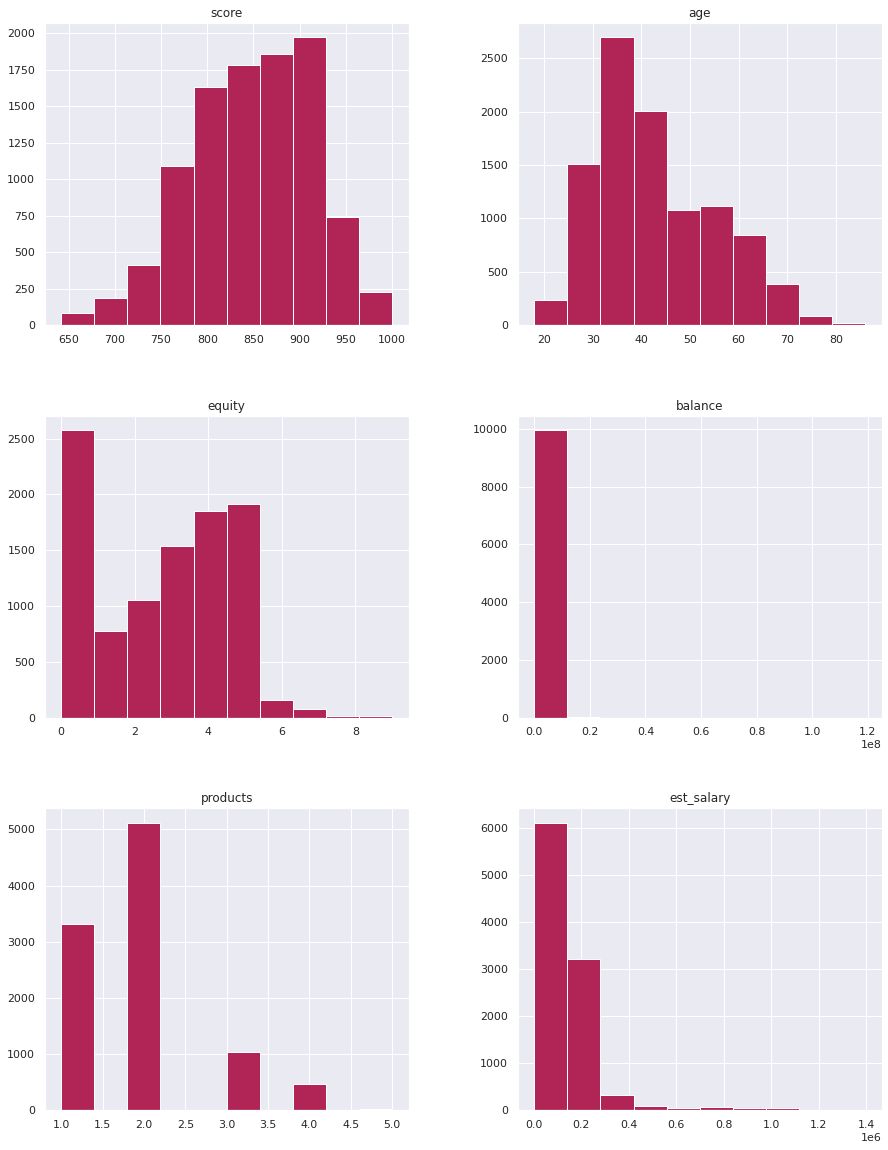

In [ ]:
#matplotlib.style.use('seaborn-light')
bank.loc[:, ['score','age','equity','balance','products','est_salary']].hist(figsize=(15, 20), color="#b02556")
palette = sns.color_palette("flare")

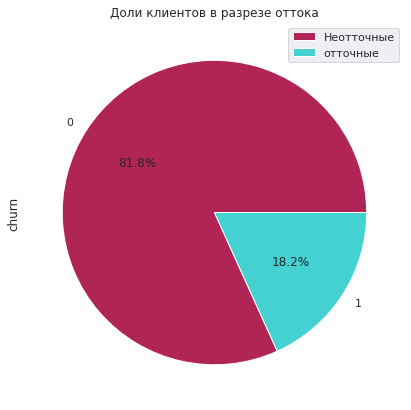

In [ ]:
churn_perc = bank.groupby('churn').agg({'churn': 'count'})
churn_perc.plot(kind='pie', y='churn', autopct='%1.1f%%', figsize=(7,7), colors=["#b02556", "#43d1d1"])
plt.title('Доли клиентов в разрезе оттока')
plt.legend(['Неотточные', 'отточные'])
plt.show()

Всего о желании отказаться от услуг банка заявило 18,2% клиентов, что, конечно, очень много. Рассмотрим детально.

In [ ]:
portrait1=bank.groupby('churn')['age', 'equity', 'est_salary', 'products','score'].agg('mean')
portrait1['balance']=bank[bank['balance']!=0].groupby('churn')['balance'].agg('mean')
portrait1=portrait1.T
portrait1.columns= ['неотточные', 'отточные']
portrait1

,неотточные,отточные
age,43.020846,4.142959e+01
equity,2.378296,3.763476e+00
est_salary,147674.637881,1.483575e+05
products,1.758921,2.377338e+00
score,845.396199,8.633619e+02
balance,733280.664167,1.134458e+06


Из простой таблицы на первый взгляд можно сделать такой вывод: балл собственности у отточных клиентов выше, баланс у отточных клиентов существенно выше, существенной разницы в зарплате не наблюдается, количество продуктов банка, которыми пользуются отточные клиенты - выше, балл кредитного рейтинга несущественно выше.  

In [ ]:
portrait2=bank.groupby('churn')['credit_card', 'last_activity', 'gender_Ж', 'gender_М'].agg('sum').T
#portrait1.columns= ['неотточные', 'отточные']
#portrait1['credit_card']=portrait2['credit_card']
portrait2.columns= ['неотточные', 'отточные']
portrait2['% неотточных']= round(portrait2 ['неотточные']/(portrait2['неотточные']+portrait2 ['отточные'])*100,1)
portrait2['% отточных']= round(portrait2 ['отточные']/(portrait2['неотточные']+portrait2 ['отточные'])*100,1)
portrait2

,неотточные,отточные,% неотточных,% отточных
credit_card,5781.0,1003.0,85.2,14.8
last_activity,3938.0,1277.0,75.5,24.5
gender_Ж,4347.0,635.0,87.3,12.7
gender_М,3808.0,1183.0,76.3,23.7


По категориальным показателям необходимо сравнение с центральной тенденцией (см.ниже), но очевидно, мужчины менее лояльны, чем женщины

### Рассмотрим распределение непрерывных характеристик ###

Для непрерывных характеристик (баланс, баллы кредитного скоринга, возраст и оценочный доход клиента) построим гистограммы или kde-графики

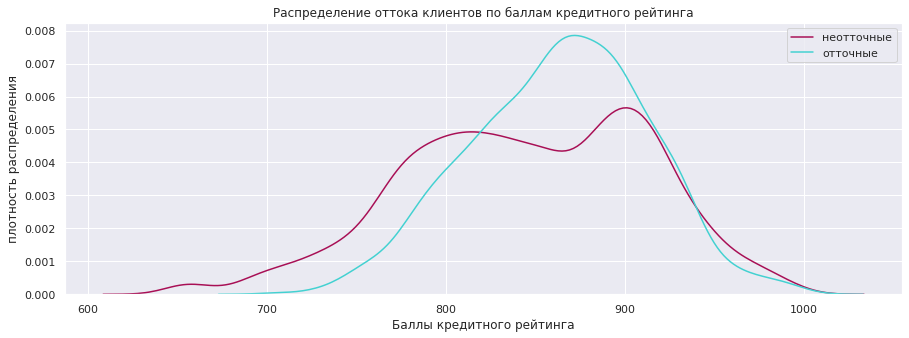

In [ ]:
plt.figure(figsize=(15,5))
sns.kdeplot(bank[bank['churn'] == 0]['score'], common_norm=False, color='#a80f55')
sns.kdeplot(bank[bank['churn'] == 1]['score'], common_norm=False, color='#43d1d1')
plt.title(f'Распределение оттока клиентов по баллам кредитного рейтинга')
plt.legend(['неотточные','отточные'])
plt.xlabel('Баллы кредитного рейтинга')
plt.ylabel('плотность распределения')
plt.show();

ВЫВОД: если делить график по пересечениям отточной и неотточной, то можно выделить 3 интервала: в интервале до 820 преобладают неотточные клиенты, в интервале 820-935 - отточные, выше 935 - опять неотточные. Интервал 820-935 можно включить в сегментационный признак.

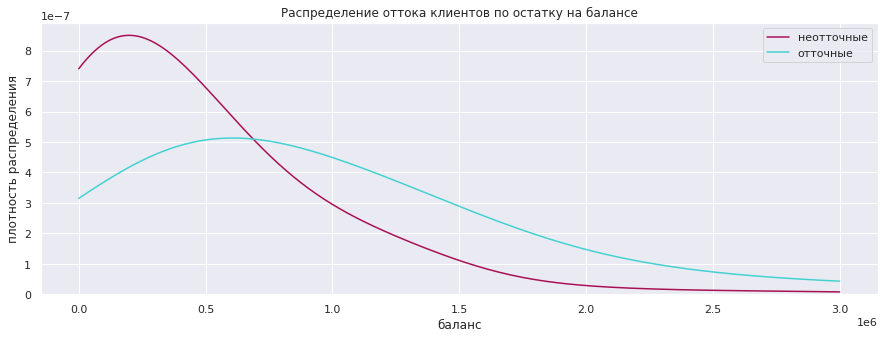

In [ ]:
plt.figure(figsize=(15,5))
sns.kdeplot(bank[bank['churn'] == 0]['balance'], clip=(0, 3000000), common_norm=False, color='#a80f55')
sns.kdeplot(bank[bank['churn'] == 1]['balance'], clip=(0, 3000000), common_norm=False, color='#43d1d1')
plt.title(f'Распределение оттока клиентов по остатку на балансе')
plt.legend(['неотточные','отточные'])
plt.xlabel('баланс')
plt.ylabel('плотность распределения')
plt.show();

ВЫВОД: наименьшую лояльность проявляют клиенты с балансом более 700 000 руб.

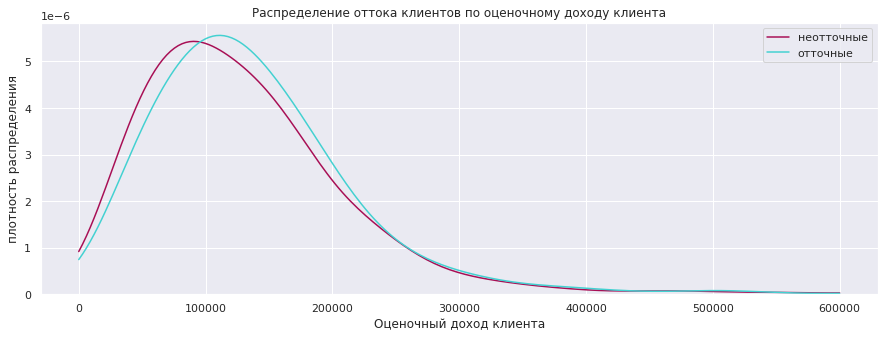

In [ ]:
plt.figure(figsize=(15,5))
sns.kdeplot(bank[bank['churn'] == 0]['est_salary'], clip=(0, 600000), common_norm=False, color='#a80f55')
sns.kdeplot(bank[bank['churn'] == 1]['est_salary'], clip=(0, 600000), common_norm=False, color='#43d1d1')
plt.title(f'Распределение оттока клиентов по оценочному доходу клиента')
plt.legend(['неотточные','отточные'])
plt.xlabel('Оценочный доход клиента')
plt.ylabel('плотность распределения')
plt.show();

ВЫВОД: по оценочному доходу клиентов также выделяется 3 сегмента, их которых второй является более отточным, у него пересечения происходят на уровне 95000 и 260000

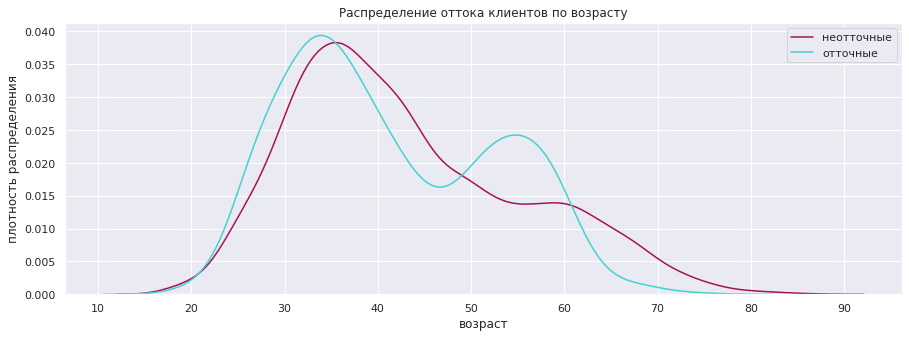

In [ ]:
plt.figure(figsize=(15,5))
sns.kdeplot(bank[bank['churn'] == 0]['age'], common_norm=False, color='#a80f55')
sns.kdeplot(bank[bank['churn'] == 1]['age'], common_norm=False, color='#43d1d1')
plt.title(f'Распределение оттока клиентов по возрасту')
plt.legend(['неотточные','отточные'])
plt.xlabel('возраст')
plt.ylabel('плотность распределения')
plt.show();

ВЫВОД: по пересечениям выделяются такие возрастные группы:  
до 22 - неотточных больше  
22-35 отточных больше  
36-48 - неотточных больше
48-62 - отточных больше
62+ - неотточных больше

In [ ]:
def group_by_age (age):
    if age < 22:
        return '18-22'
    if 23 <= age <= 35:
        return '23-35'
    if 36 <= age <= 48:
        return '36-48'
    if 49 <= age <= 62:
        return '49-62'
    if 63 <= age:
        return '63+'


In [ ]:
bank1['age_group'] = bank1['age'].apply(group_by_age)
display(bank1.sample(5))

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_group
3548,146889,714.0,Рыбинск,М,37.0,0,0.00,1,1,1,341121.65,0,36-48
3081,164392,914.0,Ростов,М,32.0,4,274454.62,2,1,0,229907.68,0,23-35
5261,195721,896.0,Рыбинск,Ж,42.0,0,0.00,1,1,1,155232.07,0,36-48
5907,116282,814.0,Ярославль,М,44.0,5,1618334.48,3,0,1,91458.13,1,36-48
1127,178759,930.0,Рыбинск,М,49.0,5,1285219.95,2,0,0,187849.73,0,49-62


### Изучение категориальных характеристик в разрезе оттока ###

In [ ]:
def categ_share (column):
    categ = []
    categ = bank.pivot_table (index = column, values = 'churn', aggfunc = ['sum', 'count'])
    categ.columns = categ.columns.droplevel(level=1)
    categ['perc'] = round(categ['sum']/categ['count'],2)
    return categ

In [ ]:
categ_share('equity').T

equity,0,1,2,3,4,5,6,7,8,9
sum,90.00,93.00,166.00,321.00,464.00,576.0,58.00,37.00,6.00,7.00
count,2576.00,773.00,1051.00,1540.00,1847.00,1915.0,161.00,80.00,17.00,13.00
perc,0.03,0.12,0.16,0.21,0.25,0.3,0.36,0.46,0.35,0.54


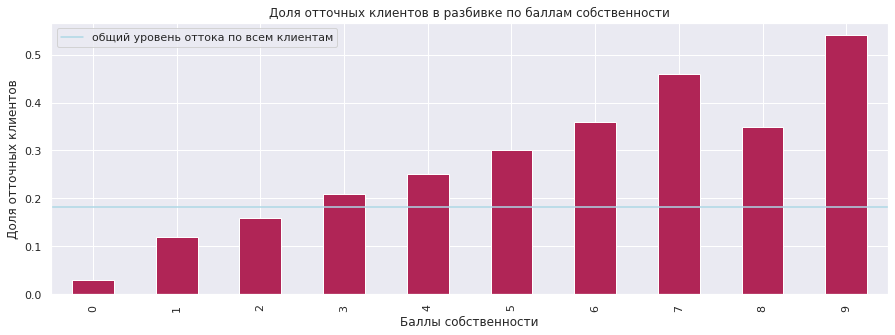

In [ ]:
# Построим столбчатую диаграмму:
categ_share('equity')['perc'].plot(
    kind='bar',
    title = 'Доля отточных клиентов в разбивке по баллам собственности',
    xlabel = 'Баллы собственности',
    ylabel = 'Доля отточных клиентов',
    figsize = (15,5),
    color = '#b02556').axhline(bank.churn.mean(),c='lightblue')
plt.legend(labels=['общий уровень оттока по всем клиентам']);

Чем выше балл собственности клиента банка -  тем выше показатель оттока.

In [ ]:
# Распределение ушедших клиентов по числу продуктов банка:
categ_share('products').T

products,1,2,3,4,5
sum,235.00,978.00,297.00,300.00,8.00
count,3323.00,5119.00,1038.00,474.00,19.00
perc,0.07,0.19,0.29,0.63,0.42


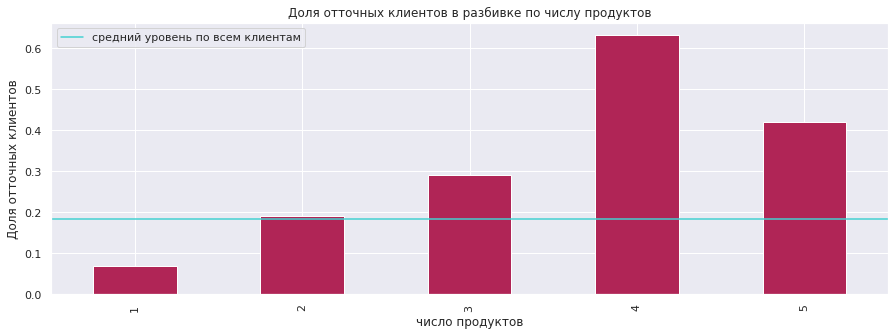

In [ ]:
# Построим столбчатую диаграмму:
categ_share('products')['perc'].plot(
    kind='bar',
    title = 'Доля отточных клиентов в разбивке по числу продуктов',
    xlabel = 'число продуктов',
    ylabel = 'Доля отточных клиентов',
    figsize = (15,5),
    color = '#b02556').axhline(bank.churn.mean(),c='#43d1d1')
plt.legend(labels=['средний уровень по всем клиентам']);

Показатель оттока выше у тех клиентов, которые пользуются большим количеством продуктов банка.

In [ ]:
# тут работаем с "костылем", который пришлось делать из-за drop_first в get_dummies
def categ_share1 (column):
    categ1 = []
    categ1 = bank1.pivot_table (index = column, values = 'churn', aggfunc = ['sum', 'count'])
    categ1.columns = categ1.columns.droplevel(level=1)
    categ1['perc'] = round(categ1['sum']/categ1['count'],2)
    return categ1

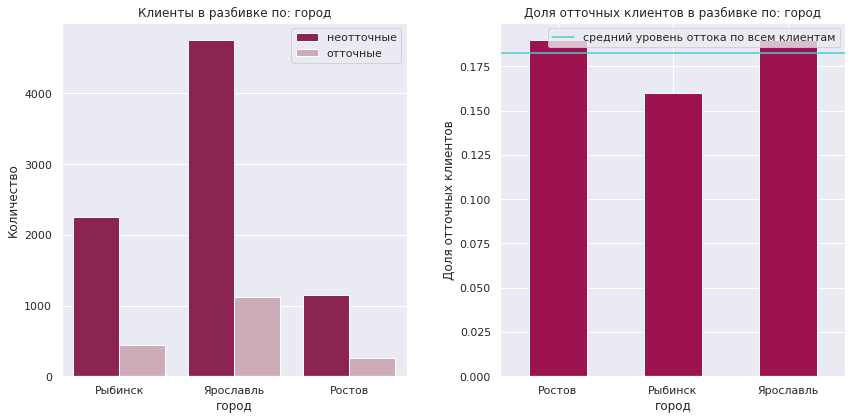

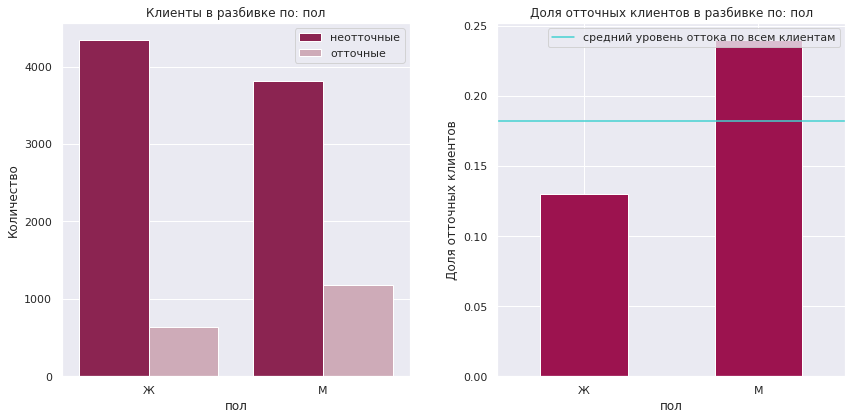

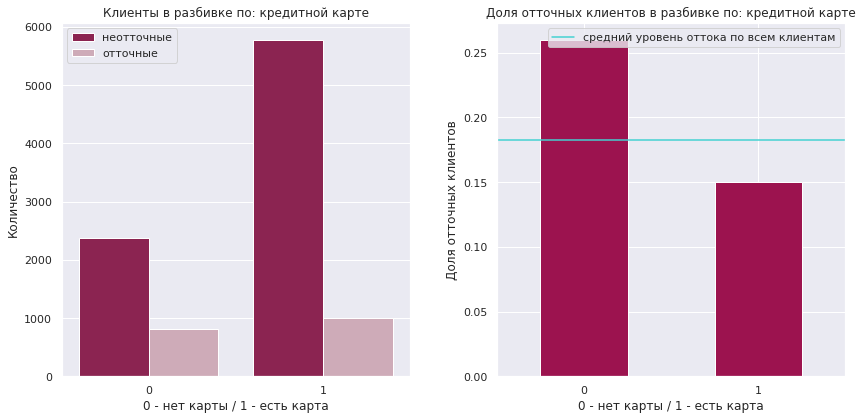

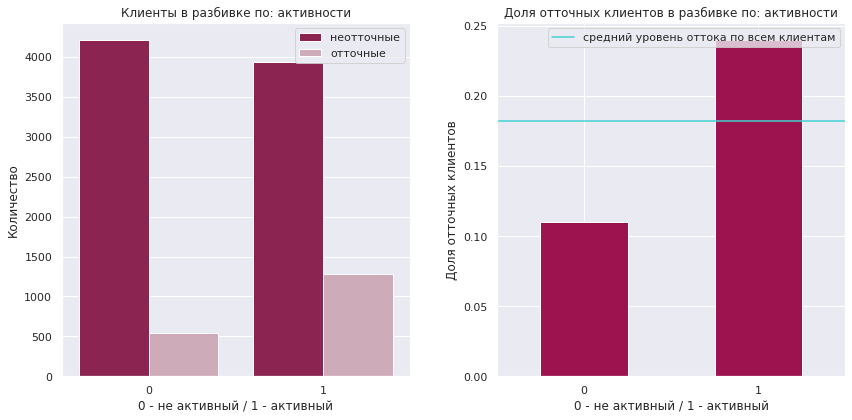

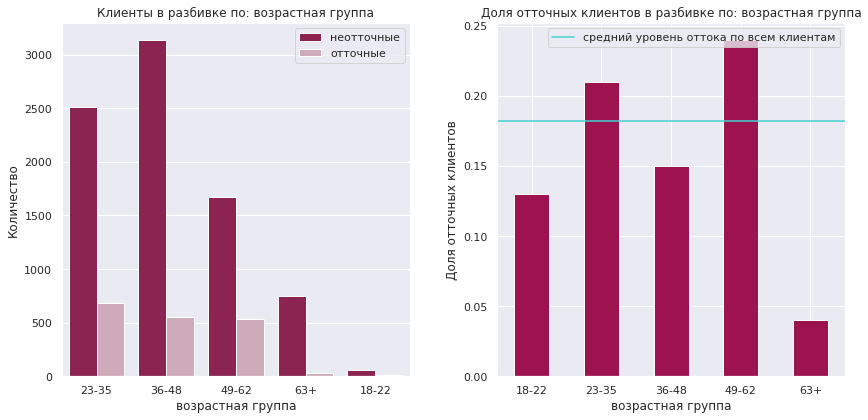

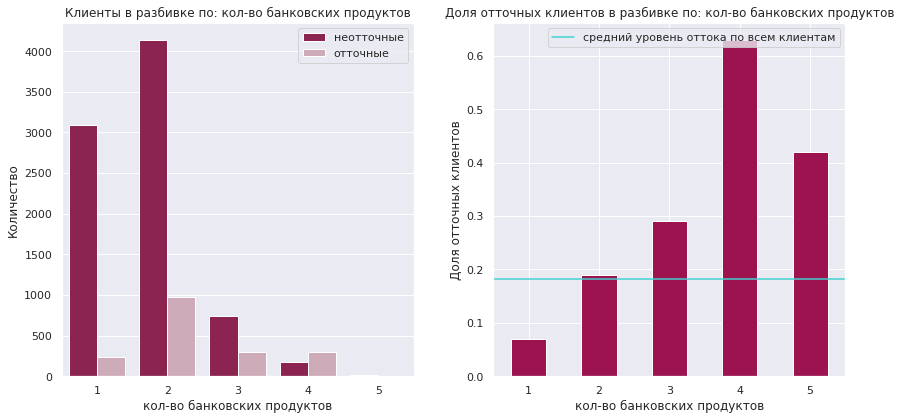

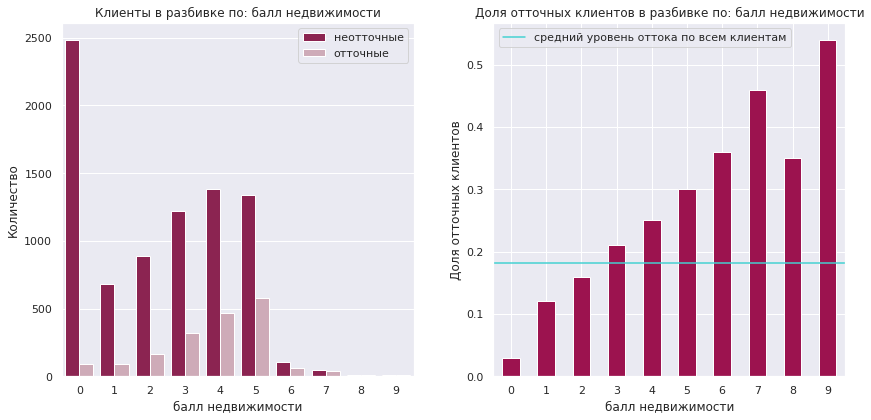

In [ ]:
column_to_xlabel_name = {'city':'город',
                         'credit_card':'0 - нет карты / 1 - есть карта',
                         'last_activity': '0 - не активный / 1 - активный',
                         'gender' : 'пол',
                         'age_group':'возрастная группа',
                         'products':'кол-во банковских продуктов',
                         'equity':'балл недвижимости'}
column_to_xlabel_name1 = {'city':'город',
                         'credit_card':'кредитной карте',
                         'last_activity': 'активности',
                         'gender' : 'пол',
                         'age_group':'возрастная группа',
                         'products':'кол-во банковских продуктов',
                         'equity':'балл недвижимости'}

for i,columns in enumerate(['city','gender', 'credit_card','last_activity', 'age_group', 'products', 'equity']): #
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    sns.countplot(data = bank1,
                  x = bank1[columns],
                  hue = 'churn', palette=['#9c134f', '#d4a5b6'],
                  ax = ax1)
    categ_share1(columns)['perc'].plot(kind='bar',
                                     title = f'Доля отточных клиентов в разбивке по: {column_to_xlabel_name1.get(columns)}',
                                     xlabel = columns,
                                     ylabel = 'Доля отточных клиентов',
                                     color = '#9c134f',
                                     figsize=(12,6),
                                     ax =ax2 ).axhline(bank1.churn.mean(),c='#43d1d1')

    ax1.legend(labels=['неотточные', 'отточные'])
    ax2.legend(labels=['средний уровень оттока по всем клиентам']);
    ax1.set_title(f'Клиенты в разбивке по: {column_to_xlabel_name1.get(columns)}')
    ax1.tick_params(labelrotation=0)
    ax1.set_ylabel('Количество')
    ax1.set_xlabel(column_to_xlabel_name.get(columns))
    ax2.set_xlabel(column_to_xlabel_name.get(columns))
    ax2.tick_params(labelrotation=0)
    plt.tight_layout(w_pad=3)
    plt.show();

В разрезе филиалов наиболее благоприятно выглядят показатели Рыбинска, показатели оттока для филиалов в Ростове и Ярославле выше среднего по банку. Возможно это связано с тем, что город небольшой с населением 183+ тыс. человек и имеет меньше представительств и филиалов банков, в то время как Ярославль с населением 577 тыс и Ростов с населением 1,1 млн могут иметь гораздо больший выбор кредитных организаций.  

Женщины проявляют бОльшую лояльность, чем мужчины.  

Клиенты с кредитной картой менее склонны к уходу из банка, чем те, которые не пользуются таким продуктом. Это отчасти тоже объяснимо тем, что если у тебя отрицательный показатель на кредитной карте, то просто так не уйдешь, нужно гасить задолженность.    

Активные клиенты более склонны к уходу из банка, чем те, кто неактивно пользуется услугами банка. Возрастные группы 23-35 и 48-62 показывают большую склонность к оттоку, при этом вторая группа представлена более обширно.

Также выше уровень выше среднего по банку показывают клиенты, у которых более 2 банковских продуктов и оценочный балл недвижимости более 3.

### Изучение всех данных на предмет наличия корреляций с целевой характеристикой ###

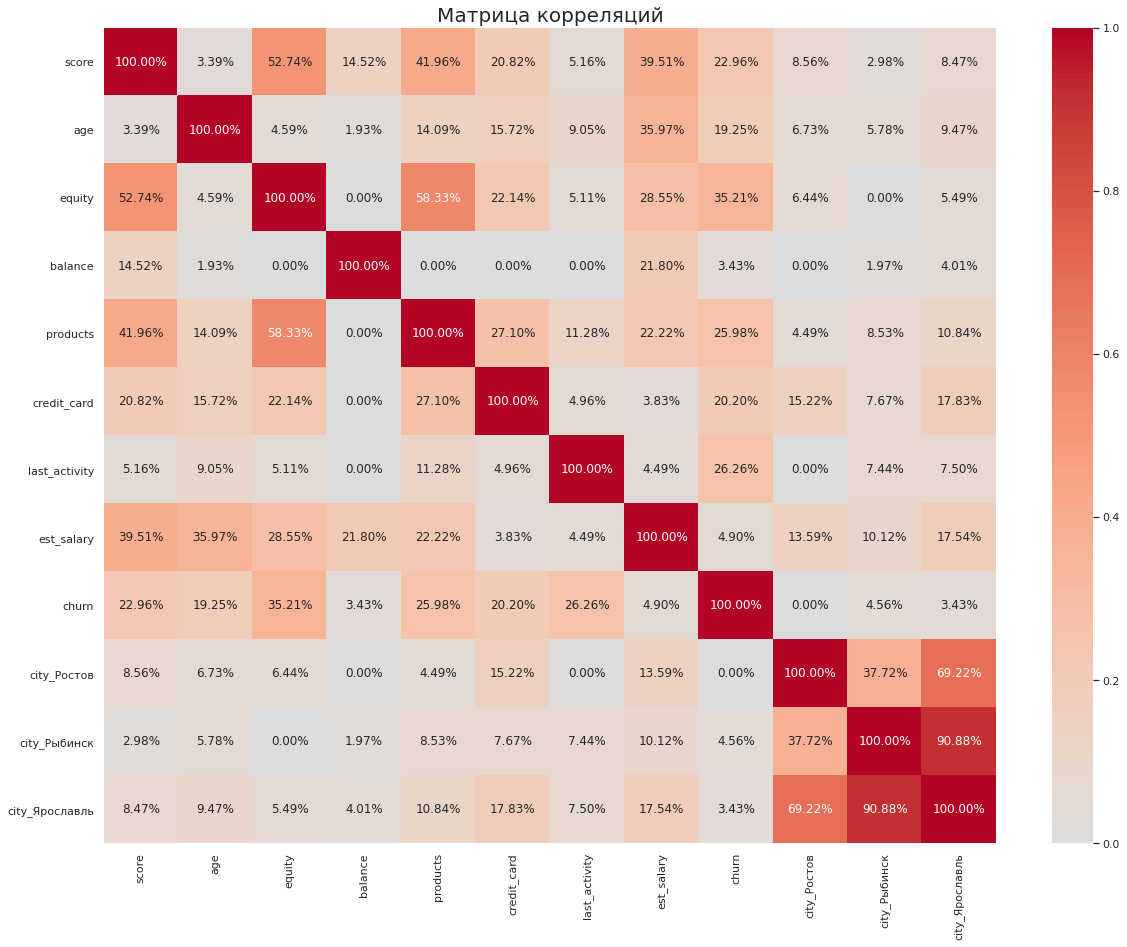

In [ ]:
bank_corr = bank.drop(['user_id', 'gender_М','gender_Ж'], axis=1)
#phik.binning.auto_bin_data(data=bank1, interval_cols: ['score', 'est_salary', 'balance', 'age'])
corr_matrix = bank_corr.phik_matrix(interval_cols=['score', 'est_salary', 'balance', 'age'])
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, center=0 ,cmap="coolwarm", annot=True, fmt='.2%')
plt.title('Матрица корреляций', fontsize = 20)
plt.show()

По шкале Чеддока умеренная корреляция оттока отмечена в связи с баллом недвижимости (35,21%), с остальными показателями -  связь слабая, разве что связь в районе 26% можно отметить количество банковских продуктов и активность клиента, в районе 22% колеблется связь по кредитному скорингу и полу.

In [ ]:
bank_corr.head(5)

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль
0,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0
1,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0
2,892.0,30.0,0,0.00,1,1,1,107683.34,0,0,1,0
3,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,1


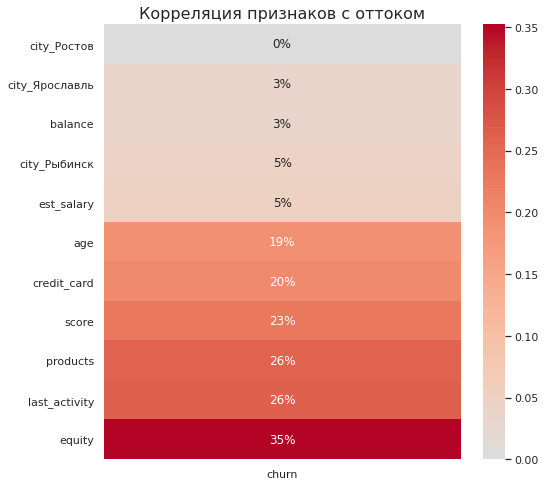

In [ ]:
# построим отдельно тепловую карту корреляций признаков непосредственно с оттоком
plt.figure(figsize=(8,8))
sns.heatmap(
    corr_matrix.loc[:,['churn']].drop('churn').sort_values('churn'),
    annot=True, fmt='.0%', cmap='coolwarm', center=0
)
plt.title('Корреляция признаков с оттоком', fontsize = 16)
plt.show()

## Статистический анализ оттока ##

### Выбор статистического критерия и обоснование этого выбора  

T-тест можно применять при соблюдении следующих трех условий:  
 - генеральные совокупности не зависят друг от друга;
 - выборочные средние нормально распределены;
 - дисперсии рассматриваемых генеральных совокупностей равны.

In [ ]:
# оценим дисперсии для дохода клиента, т.к. этот показатель и показатель баланса могут наиболее сильно отличаться
print('Дисперcия дохода отточных клиентов',bank[bank['churn'] == 1]['est_salary'].var())
print('Дисперcия дохода неотточных клиентов',bank[bank['churn'] == 0]['est_salary'].var())

Дисперcия дохода отточных клиентов 15112272166.883385
Дисперcия дохода неотточных клиентов 20358839437.943962


Text(0.5, 1.0, 'Гистограмма по доходу')

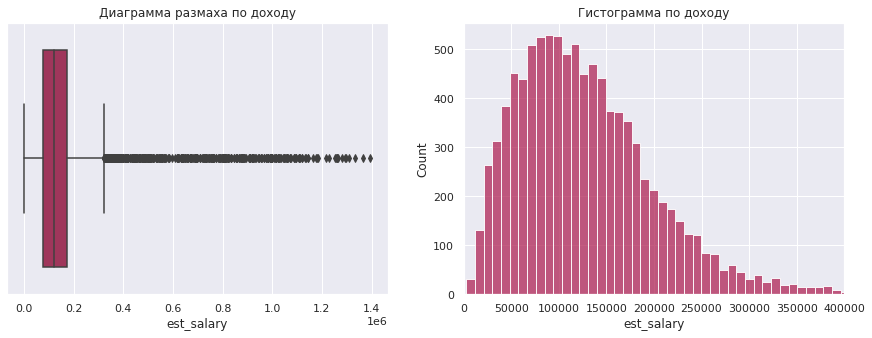

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.xlim(0, 400000)
#sns.displot(data=bank1, y='est_salary', ax=axes[0,0], common_norm=True)
sns.boxplot(data=bank1, x='est_salary', ax=axes[0], color= "#b02556")
sns.histplot(data=bank1, x='est_salary', ax=axes[1], color= "#b02556")
axes[0].set_title('Диаграмма размаха по доходу')
axes[1].set_title('Гистограмма по доходу')

Генеральные совокупности по отточным и неотточным клиентам не зависят друг от друга, дисперсии отличаются, распределение не выглядит нормальным. Если дисперсии генеральных совокупностей не равны при использования t-test можно использоовать аргумент equal_var=False, но и в этом случае результат может быть не точным.

Главное отличие непараметрических методов (u-test Манна-Уитни) в том, что они работают с рангами, — номерами значений в упорядоченном ряду, — никак не учитывая сами значения, поэтому к ним прибегают тогда, когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих параметрические результаты. В банках клиенты с высокими доходами и с большим балансом на счете являются наиболее ценными, поэтому в этом анализе убирать эти значения не стоит, и в части таких показателей, как доход или баланс u-test подходит больше.

### Формулирование гипотез

1. H₀: средние доходы оставшихся и отточных клиентов равны H₁: средние доходы оставшихся и отточных клиентов не равны  
2. H₀: средние балансы отточных и неотточных клиентов равны, H₁: средние балансы отточных и неотточных клиентов не равны  
3. H₀: средние кредитные скоринги отточных и неотточных клиентов равны, H₁: средние кредитные скоринги отточных и неотточных клиентов не равны  
4. H₀: среднее количество продуктов отточных и неотточных клиентов равно, H₁: среднее количество продуктов отточных и неотточных клиентов не равно  
5. H₀: среднее количеству баллов собственности отточных и неотточных клиентов равно, H₁: среднее количество баллов собственности отточных и неотточных клиентов не равно  
6. H₀: Доли отточных и неотточных клиентов среди активных пользователей равны, H₁: Доли отточных и неотточных клиентов среди активных пользователей не равны  
7. H₀: Доли отточных и неотточных клиентов среди пользователей кредитных карт равны, H₁: Доли отточных и неотточных клиентов среди пользователей кредитных карт не равны

<b> Гипотеза №1: различие доходов оставшихся и отточных клиентов


Сформулируем нулевую и альтернативную гипотезы:

H₀: средние доходы оставшихся и отточных клиентов равны  
H₁: средние доходы оставшихся и отточных клиентов не равны

Первую гипотезу, о том, влияет ли отток на доходы клиентов, необходимо проверить и t-критерием и u-критерием, объяснить расхождения

In [ ]:
# t-test
result_salary = st.ttest_ind (
    bank[bank['churn']==0]['est_salary'],
    bank[bank['churn']==1]['est_salary'], equal_var = False)

alpha = 0.05
print ('p-значение:', result_salary.pvalue)
if result_salary.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.8354803526840116
Не получилось отвергнуть нулевую гипотезу


In [ ]:
# u-test
result_salary_u = st.mannwhitneyu(bank.query('churn == 0')['est_salary'],
                           bank.query('churn == 1')['est_salary'])
print('p-значение:', result_salary_u.pvalue)
if result_salary_u.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.00016830729188229058
Отвергаем нулевую гипотезу


In [ ]:
#посмотрим выбросы по доходу
print(np.percentile(bank['est_salary'], [90, 95, 99]))

[242322.348  316366.936  886343.7136]


Тесты показали разный результат: t-test говорит о том, что средние доходы равны, а u-test - что не равны.  Почему результаты отличаются? Главное отличие непараметрических методов (в данном случае Манна-Уитни) в том, что они работают с рангами, — номерами значений в упорядоченном ряду, — никак не учитывая сами значения, поэтому к ним прибегают тогда, когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих параметрические результаты. В банках клиенты с высокими доходами и с большим балансом на счете являются наиболее ценными, поэтому в этом анализе убирать эти значения не стоит, и в части таких показателей, как доход или баланс u-test подходит больше, поэтому  
ВЫВОД: средний уровень дохода отточных и неотточных клиентов различаются

<b> Гипотеза №2: различие балансов отточных и неотточных клиентов


Сформулируем нулевую и альтернативную гипотезы:

H₀: средние балансы отточных и неотточных клиентов равны  
H₁: средние балансы отточных и неотточных клиентов не равны

Т.к. здесь тоже возможны большие разбросы в значениях, посмотрим выбросы, распределение и дисперсию

Text(0.5, 1.0, 'Гистограмма по балансу')

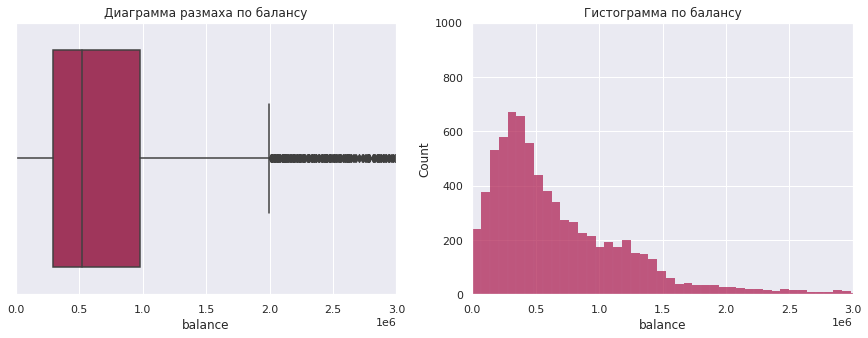

In [ ]:
# смотрим выбросы и распределение
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=bank1[(bank['balance']!=0)], x='balance', ax=axes[0], color= '#b02556')
sns.histplot(data=bank1[(bank['balance']!=0)], x='balance', ax=axes[1], color= "#b02556")
axes[0].set_xlim([0, 3000000])
axes[1].set_xlim([0, 3000000])
axes[1].set_ylim([0, 1000])
axes[0].set_title('Диаграмма размаха по балансу')
axes[1].set_title('Гистограмма по балансу')

In [ ]:
# оценим дисперсии для баланса клиента, т.к. этот показатель и показатель баланса могут наиболее сильно отличаться
print('Дисперcия балансов отточных клиентов',bank[(bank['churn']==1) & (bank['balance']!=0)]['balance'].var())
print('Дисперcия баланса неотточных клиентов',bank[(bank['churn']==0) & (bank['balance']!=0)]['balance'].var())

Дисперcия балансов отточных клиентов 4138968690585.886
Дисперcия баланса неотточных клиентов 3819044954022.5933


проверим и t-критерием и u-критерием

In [ ]:
result_balance = st.ttest_ind (
    bank[(bank['churn']==0) & (bank['balance']!=0)]['balance'],
    bank[(bank['churn']==1) & (bank['balance']!=0)]['balance'], equal_var = False)

alpha = 0.05
print ('p-значение:', result_balance.pvalue)

if result_balance.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.798263833623908e-13
Отвергаем нулевую гипотезу


In [ ]:
result_balance_u = st.mannwhitneyu( bank[(bank['churn']==0) & (bank['balance']!=0)]['balance'],
                           bank[(bank['churn']==1) & (bank['balance']!=0)]['balance'])
print('p-значение:', result_balance_u.pvalue)
if result_balance_u.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.999424249740565e-70
Отвергаем нулевую гипотезу


In [ ]:
#посмотрим 50й, 90-й, 95й и 99й персентили по балансу
print(np.percentile(bank[(bank['balance']!=0)]['balance'], [50, 90, 95, 99]))

[ 524417.66  1460158.524 2114603.672 4827216.322]


ВЫВОД: В случае с балансом клиентов оба теста показали, что балансы отточных клиентов и неотточных не равны.

<b> Гипотеза №3: различие по кредитному скорингу отточных и неотточных клиентов

Сформулируем нулевую и альтернативную гипотезы:

H₀: средние кредитные скоринги отточных и неотточных клиентов равны   
H₁: средние кредитные скоринги отточных и неотточных клиентов не равны

In [ ]:
result_score = st.ttest_ind (
    bank[bank['churn']==0]['score'],
    bank[bank['churn']==1]['score'], equal_var = False)

alpha = 0.05
print ('p-значение:', result_score.pvalue)

if result_score.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.3179430198200596e-37
Отвергаем нулевую гипотезу


ВЫВОД: средний кредитный скоринг у отточных и неотточных клиентов отличается

<b> Гипотеза №4: различие по кредитному скорингу отточных и неотточных клиентов

Сформулируем нулевую и альтернативную гипотезы:

H₀: среднее количество продуктов отточных и неотточных клиентов равно   
H₁: среднее количество продуктов отточных и неотточных клиентов не равно

In [ ]:
result_products = st.ttest_ind (
    bank[bank['churn']==0]['products'],
    bank[bank['churn']==1]['products'], equal_var = False)

alpha = 0.05
print ('p-значение:', result_products.pvalue)

if result_products.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2671065900765871e-138
Отвергаем нулевую гипотезу


ВЫВОД: среднее количество банковских продуктов у отточных и неотточных клиентов отличается

<b> Гипотеза №5: различие по количеству баллов собственности отточных и неотточных клиентов

Сформулируем нулевую и альтернативную гипотезы:

H₀: среднее количеству баллов собственности отточных и неотточных клиентов равно  
H₁: среднее количество баллов собственности отточных и неотточных клиентов не равно

In [ ]:
result_equity = st.ttest_ind (
    bank[bank['churn']==0]['equity'],
    bank[bank['churn']==1]['equity'], equal_var = False)

alpha = 0.05
print ('p-значение:', result_equity.pvalue)

if result_equity.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.2265321241808214e-196
Отвергаем нулевую гипотезу


ВЫВОД: среднее количество банковских продуктов у отточных и неотточных клиентов отличается

<b> Гипотеза №6: различие долей отточных и неотточных клиентов среди активных клиентов

Сформулируем нулевую и альтернативную гипотезы:

H₀: доли отточных клиентов и неотточных клиентов среди активных клиентов равны  
H₁: доли отточных клиентов и неотточных клиентов среди активных клиентов не равны

Попробуем применить z-test (так себе вышла проба)

In [ ]:
alpha = 0.05  # критический уровень статистической значимости

churn0_act=len(bank[(bank['churn']==0) & (bank['last_activity']==1)])
churn1_act=len(bank[(bank['churn']==1) & (bank['last_activity']==1)])
active=len(bank[(bank['last_activity']==1)])

p1=churn0_act/active
p2=churn1_act/active
p_combined=(churn0_act+churn1_act)/(active+active)

difference=p1-p2

z_value = difference / mth.sqrt(p_combined*(1-p_combined)*(1/active + 1/active))

distr=st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value)))*2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


ВЫВОД: Доли отточных и неотточных клиентов среди активных пользователей отличаются.

<b> Гипотеза №7: равенство долей отточных и неотточных клиентов среди владельцев кредитных карт банка  

Сформулируем нулевую и альтернативную гипотезы:

H₀: доли отточных и неотточных клиентов среди владельцев кредитных карт равны  
H₁: доли отточных и неотточных клиентов среди владельцев кредитных карт не равны

In [ ]:
alpha = 0.05  # критический уровень статистической значимости

churn0_card=len(bank[(bank['churn']==0) & (bank['credit_card']==1)])
churn1_card=len(bank[(bank['churn']==1) & (bank['credit_card']==1)])
card=len(bank[(bank['credit_card']==1)])

p1=churn0_card/card
p2=churn1_card/card
p_combined=(churn0_card+churn1_card)/(card+card)

difference=p1-p2

z_value = difference / mth.sqrt(p_combined*(1-p_combined)*(1/active + 1/active))

distr=st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value)))*2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


ВЫВОД: доли отточных и неотточных клиентов среди пользователей кредитных карт отличаются.

## Промежуточный вывод ##

На основании исследовательского анализа и статистического анализа делаем вывод о том, какие показатели влияют на отток

В разрезе филиалов наиболее благоприятно выглядят показатели Рыбинска, показатели оттока для филиалов в Ростове и Ярославле выше среднего по банку. Возможно это связано с тем, что город небольшой с населением 183+ тыс. человек и имеет меньше представительств и филиалов банков, в то время как Ярославль с населением 577 тыс и Ростов с населением 1,1 млн могут иметь гораздо больший выбор кредитных организаций.  

Женщины проявляют бОльшую лояльность, чем мужчины.  

Клиенты с кредитной картой менее склонны к уходу из банка, чем те, которые не пользуются таким продуктом. Это отчасти тоже объяснимо тем, что если у тебя отрицательный показатель на кредитной карте, то просто так не уйдешь, нужно гасить задолженность.  
Активные клиенты более склонны к уходу из банка, чем те, кто неактивно пользуется услугами банка. Возрастные группы 23-35 и 48-62 показывают большую склонность к оттоку, при этом вторая группа представлена более обширно.

О чем можно сказать, изучив таблицу корреляции? Таблица корреляции показывает, что по шкале Чеддока умеренная корреляция оттока отмечена в связи с баллом недвижимости (35,21%), с остальными показателями - связь слабая, разве что связь в районе 25% можно отметить количество банковских продуктов и активность клиента.


**Портрет лояльного клиента**
- кредитный рейтинг меньше 820 или больше 935
- баланс счета менее 700 000 руб.
- доход до 95 000 или выше 260 000 руб
- возраст до 22, между 35 и 48 или старше 62 лет
- оценочный балл недвижимости до 3
- количество продуктов банка до 2
- пол - женский

**Портрет отточного клиента**
- кредитный рейтинг 820-935
- баланс счета более 700 000 руб.
- доход в промежутке 95-260 тыс. руб
- возраст до 22-35 и 48-62 лет
- оценочный балл недвижимости выше 3
- количество продуктов банка больше 2
- пол - мужской

## Сегментация клиентов ##

### Разделение клиентов на сегменты ###  

Опираясь на уменьшение степени корреляции из показателей в первую очередь можно выделить балл недвижимости (35,21%), с остальными показателями - связь слабее, это: количество банковских продуктов и кредитный рейтинг , также по графикам можно выделить сегменты в балансе и доходе клиентов.
В данном случае активности можно говорить о том, что активный клиент является более "продвинутым" и склонен к поиску более выгодных условий, этот показатель можно применять для "сужения" сегмента, если он окажется слишком большим.
Таким образом, из вышерассмотренных признаков для сегментирования возьмем:
- оценочный балл недвижимости выше 4 (клиенты с баллом ровно 4 лишь немного пересекают линию среднего оттока по банку и с увеличением данного показателя отточность возрастает)
- количество продуктов банка больше 3 (клиенты ровно с 3 продуктами лишь немного пересекают линию среднего оттока по банку и с увеличением данного показателя отточность возрастает)
- кредитный рейтинг 820-935
- баланс счета более 700 000 руб.
- доход в промежутке 95-260 тыс. руб
- возраст до 22-35 и 48-62 лет


в ходе формирования сегментов можно будет некоторые группы объединить или сузить через показатель активности, пола или наличия кредитной карты

### Проверка корректности разбивки на сегменты  ###

In [ ]:
segment1=bank1.query('products>3').agg({"churn":["count","sum"]}).T
segment1['% оттока']=round(segment1['sum']/segment1['count']*100, 2)
segment1.columns= ['всего', 'отточные', '% оттока']
segment1

,всего,отточные,% оттока
churn,493,308,62.47


Сегмент №1 - от 4 и более банковских продуктов. Размер сегмента достаточный, выявлен большой уровень оттока - 62,47%

In [ ]:
segment2=bank1.query('balance>700000 and gender == "М" and last_activity ==1').agg({"churn":["count","sum"]}).T
segment2['%']=round(segment2['sum']/segment2['count']*100, 2)
segment2.columns= ['всего', 'отточные', '% оттока']
segment2

,всего,отточные,% оттока
churn,750,443,59.07


Сегмент №2 - активные клиенты мужского пола с балансом выше 700000 руб. Размер сегмента достаточный, выявлен большой уровень оттока - 59,07%

In [ ]:
segment3=bank1.query('equity>4 and gender == "М" and last_activity ==1').agg({"churn":["count","sum"]}).T
segment3['%']=round(segment3['sum']/segment3['count']*100, 2)
segment3.columns= ['всего', 'отточные', '% оттока']
segment3

,всего,отточные,% оттока
churn,595,324,54.45


Сегмент №3 - активные клиенты мужского пола с оценочным баллом недвижимости от 5 и более. Размер сегмента достаточный, выявлен большой уровень оттока - 54,45%

In [ ]:
segment4=bank1.query('95000<est_salary<260000 and 48<age<62 and last_activity ==1').agg({"churn":["count","sum"]}).T
segment4['%']=round(segment4['sum']/segment4['count']*100, 2)
segment4.columns= ['всего', 'отточные', '% оттока']
segment4

,всего,отточные,% оттока
churn,561,188,33.51


Сегмент №4 - активные клиенты 48-62 лет с доходом от 95 до 260 тыс. Размер сегмента достаточный, но уровень оттока не выдающийся - 33,51%. Второй возрастной промежуток не добавляем, т.к. там разрыв меньше, сегмент увеличится, а уровень оттока сегмента - уменьшится.

In [ ]:
segment5=bank1.query('820<score<935 and 48<age<62 and last_activity ==1  and gender == "М"').agg({"churn":["count","sum"]}).T
segment5['%']=round(segment5['sum']/segment5['count']*100, 2)
segment5.columns= ['всего', 'отточные', '% оттока']
segment5

,всего,отточные,% оттока
churn,255,127,49.8


Сегмент №5 - активные клиенты мужского пола 48-62 лет с кредитным скорингом 820-935. Размер сегмента недостаточный, уровень оттока неплохой, но скорее всего большинство данных клиентов уже охвачены предыдущими сегментами.

ВЫВОД: перспективы работы есть по 1-3 сегменту и возможно - по 5, если в нем останутся неохваченные первыми тремя.

## Вывод и рекомендации для заказчика ##

На основании выявленных сегментов и тенденций можно дать следующие рекомендации по удержанию клиентов

**Сегмент №1** Отточность среди клиентов банка, пользующихся 4 и более продуктами составляет 62,47%, что катастрофически много. Хорошо бы проверить, не связано ли их недовольство с каким-то определенным продуктом или отделом. Можно предложить акции и скидки на комплексное ослуживание, премиальное обслуживание, специальные условия.

**Сегмент №2** - активные клиенты мужского пола с балансом выше 700000 руб. Размер сегмента достаточный, выявлен большой уровень оттока - 59,07%, можно предложить специальные условия "повышенный процент на остаток на счете".

**Сегмент №3** - активные клиенты мужского пола с оценочным баллом недвижимости от 5 и более. Размер сегмента достаточный, выявлен большой уровень оттока - 54,45%. Для данной категории имеет смысл сделать специальные предложения по страхованию и обслуживанию недвижимости, промоакции от партнеров на клининг или ремонт.

**Сегмент №4** - не берем в работу, т.к. не достаточный уровень отточности.

**Сегмент №5** - активные клиенты мужского пола 48-62 лет с кредитным скорингом 820-935. Если по первым трем остались неохваченные клиенты - можно предложить специальные условия по кредитованию: выгодная ставка или отсрочка.